## Keras FFN weather prediction in Rostov-on-Don

In [1]:
import os

import theano
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers.core import Dense, Dropout

from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

Using Theano backend.


### Подготовим данные для обучения

In [2]:
data = open('34731.dat').readlines()

meteo = []

for d in data[42006:]:
    wmo = int(d[0:5])
    year = int(d[5:9])
    month = int(d[9:11])
    day = int(d[11:13])
    hour = int(d[13:15])
    # Humidity
    rh = int(d[15:18])
    # Height of the base of the lowest cloud
    hcld = int(d[43:45])
    # Dew point
    tdew = int(d[47:50])
    # Cloud amount
    tcld = int(d[53:55])
    # Wind direction
    wdir = int(d[61:63])
    # Wind speed
    wspd = int(d[64:66])
    # Air pressure
    stap = float(d[73:78])/10
    # Past weather code
    w = int(d[83:84])
    # Air temperature
    airt = float(d[89:93]) / 10 if d[89:93] != '9999' else 0.0
    if hour:
        meteo.append([hour, day, month, wdir, wspd, stap, airt])

meteo = np.array(meteo)

### Задаем параметры  обучающих векторов

In [3]:
num_input = 6
num_output = 1

### Построим обучающие выборки

In [4]:
scaler = MinMaxScaler()
scaler.fit(meteo)

meteo = scaler.transform(meteo)

train_size = int(len(meteo) * 0.95)
train, test = np.array(meteo[0:train_size]), np.array(meteo[train_size:len(meteo)])

train_x = np.array([d[:-num_output] for d in train])
train_y = np.array([d[num_input:] for d in train])
test_x = np.array([d[:-num_output] for d in test])
test_y = np.array([d[num_input:] for d in test])

### Строим модель нейронной сети

In [5]:
model = Sequential()
model.add(Dense(64, input_dim=num_input, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(num_output))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

### Обучаем нейронную сеть и сохраняем

In [6]:
history = model.fit(train_x, train_y, validation_data=(test_x, test_y), epochs=50, batch_size=128, verbose=2)

model.save_weights('weights.net')

Train on 65174 samples, validate on 3431 samples
Epoch 1/50
0s - loss: 0.0165 - acc: 4.6031e-05 - val_loss: 0.0056 - val_acc: 0.0000e+00
Epoch 2/50
0s - loss: 0.0052 - acc: 4.6031e-05 - val_loss: 0.0053 - val_acc: 0.0000e+00
Epoch 3/50
0s - loss: 0.0051 - acc: 4.6031e-05 - val_loss: 0.0053 - val_acc: 0.0000e+00
Epoch 4/50
0s - loss: 0.0049 - acc: 4.6031e-05 - val_loss: 0.0049 - val_acc: 0.0000e+00
Epoch 5/50
0s - loss: 0.0049 - acc: 4.6031e-05 - val_loss: 0.0050 - val_acc: 0.0000e+00
Epoch 6/50
0s - loss: 0.0048 - acc: 4.6031e-05 - val_loss: 0.0053 - val_acc: 0.0000e+00
Epoch 7/50
0s - loss: 0.0047 - acc: 4.6031e-05 - val_loss: 0.0050 - val_acc: 0.0000e+00
Epoch 8/50
1s - loss: 0.0046 - acc: 4.6031e-05 - val_loss: 0.0051 - val_acc: 0.0000e+00
Epoch 9/50
0s - loss: 0.0046 - acc: 4.6031e-05 - val_loss: 0.0048 - val_acc: 0.0000e+00
Epoch 10/50
0s - loss: 0.0045 - acc: 4.6031e-05 - val_loss: 0.0057 - val_acc: 0.0000e+00
Epoch 11/50
0s - loss: 0.0045 - acc: 4.6031e-05 - val_loss: 0.0047 - v

### Строим график обучения

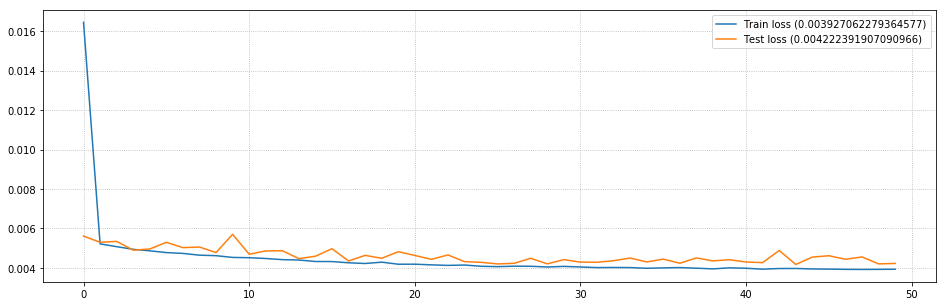

In [7]:
fig, ax = plt.subplots(figsize=(16, 5))
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.legend(['Train loss ({})'.format(history.history['loss'][-1]), \
           'Test loss ({})'.format(history.history['val_loss'][-1])])
ax.grid(ls=':')
plt.show()

### Загружаем нейронную сеть из файла

In [8]:
model.load_weights('weights.net')

### Предсказываем данные

In [9]:
test_predict = model.predict(test_x)

test_y = np.squeeze(test_y)
test_predict = np.squeeze(test_predict)

test_x_y = np.array([np.append(test_x[i], test_y[i]) for i in range(len(test_x))])
test_x_predict = np.array([np.append(test_x[i], test_predict[i]) for i in range(len(test_x))])

test_x_y = scaler.inverse_transform(test_x_y)[:, -1]
test_x_predict = scaler.inverse_transform(test_x_predict)[:, -1]

### Определяем погрешность работы сети

In [10]:
delta = np.mean(np.abs(test_x_y - test_x_predict))
print('Погрешность определения температуры: %f' % (delta))

Погрешность определения температуры: 3.282766


### Строим графики валидации на тестовой выборке

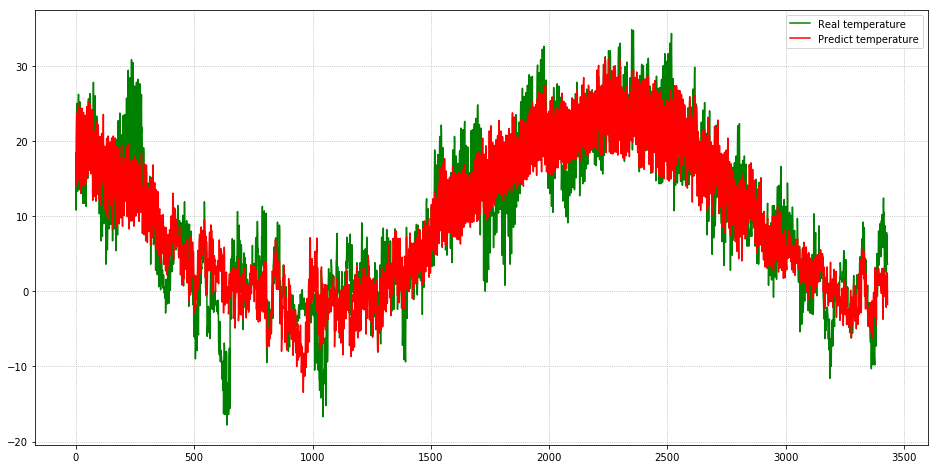

In [13]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(test_x_y[:], 'g-')
ax.plot(test_x_predict[:], 'r-')
ax.legend(['Real temperature', 'Predict temperature'])
ax.grid(ls=':')
plt.show()